#Speech Command Classifier 

** We first download the speech command dataset provided by the tensorflow team. It consists of 35 different sets of audio which represent either english commands or miscellaneous words.  There are total 105829 utterances in the dataset which is wuite impactful for deep learning tasks.**


In [1]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz  
!tar xf speech_commands_v0.01.tar.gz  

--2018-11-09 08:43:59--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.125.128, 2404:6800:4008:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.125.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  48.2MB/s    in 31s     

2018-11-09 08:44:30 (45.5 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



**Next we import necessary python modules for audio processing and deep learning framework.**

In [1]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import glob
import IPython
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from keras.utils import to_categorical
from keras.layers import Input, Add, Dropout, Dense, GRU, Bidirectional, Masking, TimeDistributed, LSTM, Conv1D, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model, Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import layer_utils, plot_model, to_categorical
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import InceptionV3
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers, losses, activations, models
from keras.initializers import glorot_uniform
from scipy.fftpack import fft
from scipy.io import wavfile
from scipy import signal
from __future__ import print_function
import keras
import copy
from keras import backend as k
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter
import scipy.ndimage
from scipy.io import wavfile

Using TensorFlow backend.


**We define several functions to convert wav audio to their spectrogram representation and also vice versa. Short-time Fourier Transformation is used for the conversion of the wav audio to spectrogram as it can be easily fed as image into the Convolutional Neural Network which gives state of the art performance for extracting features from images and classification tasks.**

In [0]:
# The credit for this section of the code goes to Tim Sainburg: https://timsainb.github.io/spectrograms-mfccs-and-inversion-in-python.html
# Most of the Spectrograms and Inversion are taken from: https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe

def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw,ws),dtype = a.dtype)

    for i in range(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start : stop]

    return out


def stft(X, fftsize=128, step=65, mean_normalize=True, real=False,
         compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)
    
    size = fftsize
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

def pretty_spectrogram(d,log = True, thresh= 5, fft_size = 512, step_size = 64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(stft(d, fftsize=fft_size, step=step_size, real=False,
        compute_onesided=True))
  
    if log == True:
        specgram /= specgram.max() # volume normalize to max 1
        specgram = np.log10(specgram) # take log
        specgram[specgram < -thresh] = -thresh # set anything less than the threshold as the threshold
    else:
        specgram[specgram < thresh] = thresh # set anything less than the threshold as the threshold
    
    return specgram

# Also mostly modified or taken from https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
def invert_pretty_spectrogram(X_s, log = True, fft_size = 512, step_size = 512/4, n_iter = 10):
    
    if log == True:
        X_s = np.power(10, X_s)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    X_t = iterate_invert_spectrogram(X_s, fft_size, step_size, n_iter=n_iter)
    return X_t

def iterate_invert_spectrogram(X_s, fftsize, step, n_iter=10, verbose=False):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    reg = np.max(X_s) / 1E8
    X_best = copy.deepcopy(X_s)
    for i in range(n_iter):
        if verbose:
            print("Runnning iter %i" % i)
        if i == 0:
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=True)
        else:
            # Calculate offset was False in the MATLAB version
            # but in mine it massively improves the result
            # Possible bug in my impl?
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=False)
        est = stft(X_t, fftsize=fftsize, step=step, compute_onesided=False)
        phase = est / np.maximum(reg, np.abs(est))
        X_best = X_s * phase[:len(X_s)]
    X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                             set_zero_phase=False)
    return np.real(X_t)

def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    size = int(X_s.shape[1] // 2)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype('float64')
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print("WARNING: Large step size >50\% detected! "
                      "This code works best with high overlap - try "
                      "with 75% or greater")
                offset_size = step
            offset = xcorr_offset(wave[wave_start:wave_start + offset_size],
                                  wave_est[est_start:est_start + offset_size])
        else:
            offset = 0
        wave[wave_start:wave_end] += win * wave_est[
            est_start - offset:est_end - offset]
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1E-6)
    return wave

def xcorr_offset(x1, x2):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype('float32'), x2[::-1].astype('float32'))
    corrs[:half] = -1E30
    corrs[-half:] = -1E30
    offset = corrs.argmax() - len(x1)
    return offset


 

**Now we initialize some helper functions and necessary parameters.**

In [0]:
def pad_audio(samples, t=1, L=8000):
    if len(samples) >= t*L: return samples
    else: return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))

def chop_audio(samples, t=1, L=8000):
    if len(samples) <= t*L: return samples
    else: return samples[0:L] 
    
def get_data(paths, label):
  
  new_sample_rate = 8000
  max_len=20
  X = []
  Y = []
 
  for i, fname in enumerate(paths):
    sample_rate, samples = wavfile.read(fname)    
    resampled = signal.resample(samples, int(8000 / sample_rate * samples.shape[0]))
    samples = pad_audio(resampled)
    samples = chop_audio(samples)
    specgram = pretty_spectrogram(samples.astype('float64'), fft_size = fft_size, 
                                   step_size = int(step_size), log = True, thresh = spec_thresh)
    Y.append(label)
    X.append(specgram)
    
    if i==len(paths)-1:
        end='\n'
    else: end='\r'
    print('processed {}/{}'.format(i+1,len(paths)),end=end)
    
  Y = to_categorical(Y, 10)
  
  return X, Y  

### Parameters ###
L = 8000 #sample rate
fft_size = 320 # window size for the FFT
step_size = fft_size/6 # distance to slide along the window (in time)
spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
lowcut = 500 # Hz # Low cut for our butter bandpass filter
highcut = 8000 # Hz # High cut for our butter bandpass filter

**A conversion of sample wav data to it's spectrogram representation is shown below. We resample the audio file with 8000 sample rate. Each audio file is padded and chopped to be of size 1 second.**

Original sample rate:  16000
Length in time (s):  1.0


Text(0.5,1.05,'Original Spectrogram')

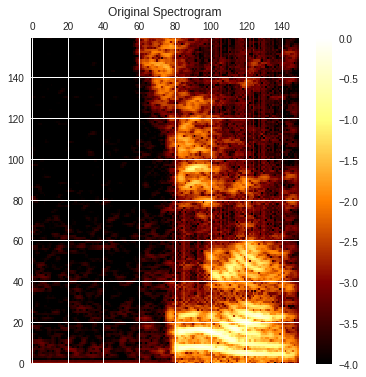

In [5]:
# Grab your wav and filter it
mywav = 'zero/0132a06d_nohash_1.wav'
rate, data = wavfile.read(mywav)
data = signal.resample(data, int(8000 / rate * data.shape[0]))
print('Original sample rate: ', rate)
rate = 8000
data = pad_audio(data)
data = chop_audio(data)
#data = butter_bandpass_filter(data, lowcut, highcut, rate, order=1)
# Only use a short clip for our demo
if np.shape(data)[0]/float(rate) > 10:
    data = data[0:rate*10] 
print('Length in time (s): ', np.shape(data)[0]/float(rate))

wav_spectrogram = pretty_spectrogram(data.astype('float64'), fft_size = fft_size, 
                                   step_size = int(step_size), log = True, thresh = spec_thresh)

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(6,6))
cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')

In [6]:
# Invert from the spectrogram back to a waveform
recovered_audio_orig = invert_pretty_spectrogram(wav_spectrogram, fft_size = fft_size,
                                            step_size = int(step_size), log = True, n_iter = 10)
print(recovered_audio_orig.shape)
IPython.display.Audio(data=recovered_audio_orig, rate=8000) # play the audio

(8110,)


**Below lines are useful to extract the paths of all the command audio files. For simplicity of demonstration and training, we choose only the audio files of ten english digits and classify them.**

In [0]:
data_dir=os.path.join('')
paths_a=glob.glob(os.path.join(data_dir,'one','*.wav'))
paths_b=glob.glob(os.path.join(data_dir,'two','*.wav'))
paths_c=glob.glob(os.path.join(data_dir,'three','*.wav'))
paths_d=glob.glob(os.path.join(data_dir,'four','*.wav'))
paths_e=glob.glob(os.path.join(data_dir,'five','*.wav'))
paths_f=glob.glob(os.path.join(data_dir,'six','*.wav'))
paths_g=glob.glob(os.path.join(data_dir,'seven','*.wav'))
paths_h=glob.glob(os.path.join(data_dir,'eight','*.wav'))
paths_i=glob.glob(os.path.join(data_dir,'nine','*.wav'))
paths_j=glob.glob(os.path.join(data_dir,'zero','*.wav'))
paths_all=paths_a+paths_b+paths_c+paths_d+paths_e+paths_f+paths_g+paths_h+paths_i+paths_j

**Now we read and preprocess all the digit speech commands and convert them to their respective spectrograms.**

In [8]:
X_a, Y_a=get_data(paths_a,1)
X_b, Y_b=get_data(paths_b,2)
X = np.concatenate((X_a, X_b), axis=0)
Y = np.concatenate((Y_a, Y_b), axis=0)
X_a, Y_a=get_data(paths_c,3)
X_b, Y_b=get_data(paths_d,4)
X = np.concatenate((X, X_a, X_b), axis=0)
Y = np.concatenate((Y, Y_a, Y_b), axis=0)
X_a, Y_a=get_data(paths_e,5)
X_b, Y_b=get_data(paths_f,6)
X = np.concatenate((X, X_a, X_b), axis=0)
Y = np.concatenate((Y, Y_a, Y_b), axis=0)
X_a, Y_a=get_data(paths_g,7)
X_b, Y_b=get_data(paths_h,8)
X = np.concatenate((X, X_a, X_b), axis=0)
Y = np.concatenate((Y, Y_a, Y_b), axis=0)
del X_b
del Y_b
X_a, Y_a=get_data(paths_i,9)
X = np.concatenate((X, X_a), axis=0)
Y = np.concatenate((Y, Y_a), axis=0)
X_a, Y_a=get_data(paths_j,0)
X = np.concatenate((X, X_a), axis=0)
Y = np.concatenate((Y, Y_a), axis=0)
X.shape, Y.shape

processed 2370/2370
processed 2373/2373
processed 2356/2356
processed 2372/2372
processed 2357/2357
processed 2369/2369
processed 2377/2377
processed 2352/2352
processed 2364/2364
processed 2376/2376


((23666, 150, 160), (23666, 10))

**After preprocessing we split the data to train and validation sets.**

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=5, shuffle=True)
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1], X_train.shape[2],1))
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1], X_val.shape[2],1)
X_train.shape, X_val.shape

((20116, 150, 160, 1), (3550, 150, 160, 1))

**Now we define the function for declaring the CNN model.**

In [0]:
def custom():
  
  model = Sequential()
  model.add(Conv2D(16, kernel_size=(7, 7), name='one', activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], 1), kernel_initializer=glorot_uniform(seed=0)))
  model.add(BatchNormalization(axis=3))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(16, kernel_size=(5, 5), name='two', activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0)))
  model.add(BatchNormalization(axis=3))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(32, kernel_size=(3, 3), name='three', activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0)))
  model.add(BatchNormalization(axis=3))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(10, activation='softmax'))
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  return model

**After designing our CNN model, we now train it for several epochs with dynamic learning rate and model checkpoint. The simple CNN model gives 95% accuracy with minimal hyper-parameter tuning.**

In [0]:
K.tensorflow_backend.clear_session()

model = custom()
model.summary()
K.set_value(model.optimizer.lr,0.001)
model_check_point = ModelCheckpoint(filepath='model.hdf5', save_best_only=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

h=model.fit(x=(X_train), y=Y_train, batch_size=32,
            epochs=15, 
            verbose=1,          
            validation_data=((X_val),Y_val),
            shuffle=True,
            callbacks=[learning_rate_reduction,model_check_point]
            )
